##  Classifying audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo<br/>
<br/>

This notebook is part of the project "Urban sounds classification with Covnolutional Neural Networks" on [my Github](https://github.com/GorillaBus/urban-audio-classifier).<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

# Basic CNN Model 

In this notebook I want to build simple yet effective convolutional model to solve a multiclass classification problem.<br/> 
I would also like to understand how the model performs for the different classes by the use of statistical tools that are not integrated in the Keras/TensorFlow packages but come by the hand of a very popular library in the field of data science with Python which is the Sci-Kit Learn package.<br/>
<br/>
Along the way I'm going to put a big effort in describing the reasons why I implement different techniques/methods and how did I reach my results.<br/>
<br/>

INDEX

1. Data preparation: features + metadata
2. A basic CNN model
3. An improved CNN model
4. Model evaluation
5. Weighted classes
6. Exploring the misclassified
7. Conclusion
8. Next


<br/>
<br/>

#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

Using TensorFlow backend.


#### * Setup

In [2]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [3]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

#### * Load data

Data v1 is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with 40 MFCC bands and 174 frames each. Each feature was channel-normalized during extraction and we are now zero-centering and scaling between -1 and 1.<br/>
<br/>

In [4]:
# Pre-processed MFCC coefficients
X = np.load("data/X-v1.npy")
y = np.load("data/y-v1.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

In [5]:
# Scale features between -1 and 1 (zero centered)
X = helpers.scale(X, -1, 1)

### 1. Data preparation: features + metadata

#### 1.1 Train / Test split
Note that we are using the same index order for both the MFCC arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [83]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### 1.2 One hot encode labels

In [7]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [8]:
# How data should be structured
num_rows = 40
num_columns = 174 # Max frame per channel, with padding
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

#### 1.4 Considerations

In Notebook #1 we took a look at the class balance of our dataset:<br/>
    
    * jackhammer          1000
    * air_conditioner     1000
    * dog_bark            1000
    * engine_idling       1000
    * street_music        1000
    * children_playing    1000
    * drilling            1000
    * siren                929
    * car_horn             429
    * gun_shot             374

A common problem in multi-class classification comes from imbalanced datasets where the classifier tends to learn more about classes that contain more samples, as a result the classes with less samples are predicted with more error and less accuracy. Normally, this occurs when the difference ratio is large enough. In our case we have two classes that contain much less ocurrences: if the model shows difficulty on this classes we can try using class weights. We'll analyze this after training checking precision, recall and f1 scores.<br/>
<br/>

### 2. A basic CNN model

Convolutional layers in a neural network work by creating feature maps that represent different components/patterns from the input data (like pixel values from images, or in this case, MFCC coefficients generated from audio signals).<br/>
<br/>
*Explaining details about the process of convolution is not in the aim of this notebook, but if you are in doubt, I would suggest to watch [this very complete video](https://www.youtube.com/watch?v=FmpDIaiMIeA) explaining the process.*<br/>
<br/>

In this first approach I started from the simplest possible CNN model and started to add complexity once it overfitted the train data.<br/> Here is the history of changes to reach the final version:<br/>

<br/>
<br/>

    =============================================================================
    #1 - Starting point
    conv 1: 16 (3x3) filters
    conv 2: 32 (3x3) filters
    lr: 1e-3
    bz: 128
    epochs: 100
    observation: Very large LR (validation loss oscilates up/down)

    #2 - Reduced LR to 1e-4
    conv 1: 16 (3x3) filters
    conv 2: 32 (3x3) filters
    lr: 1e-4
    bz: 128
    epochs: 100
    observation: Val loss now smooth, no overfit, low accuracy, tiny error gap

	#3 - Increased capacity: filter amount set to 32 / 32
	conv 1: 32 (3x3) filters
	conv 2: 32 (3x3) filters
	lr: 1e-4
	bz: 128
	epochs: 100
	observation: Improved accuracy by a little amount, still very small error gap

	#4 - Increassed first convolution filter size to 5x5
	conv 1: 32 (5x5) filters
	conv 2: 32 (3x3) filters
	lr: 1e-4
	bz: 128
	epochs: 100
	observation: Sensible accuracy increase, err gap still very small

	#5 - Doubled conv filter amounts
	regularization: none
	conv 1: 64 (5x5) filters
	conv 2: 64 (3x3) filters
	lr: 1e-4
	bz: 128
	epochs: 100
	observation: Accuracy around 75, error gap around 4%

    =============================================================================
    
To train more epochs I would need more capacity and probably start applying regularization, so I set a first checkpoint here.

<br/>

#### 2.1 Define the model

In [103]:
# Create a secquential object
model = Sequential()

#model.add(GaussianNoise(noise, input_shape=(num_rows, num_columns, num_channels)))

# Conv 1
model.add(Conv2D(filters=64, 
                 kernel_size=(5,5),  
                 input_shape=(num_rows, num_columns, num_channels), 
                 activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 input_shape=(num_rows, num_columns, num_channels), 
                 activation='relu'))
model.add(BatchNormalization())


# Reduces each h×w feature map to a single number by taking the average of all h,w values.
model.add(GlobalAveragePooling2D())


# Softmax output
model.add(Dense(num_labels, activation='softmax'))

#### 2.2 Compile and plot the model summary

In [104]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 36, 170, 64)       1664      
_________________________________________________________________
batch_normalization_43 (Batc (None, 36, 170, 64)       256       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 34, 168, 64)       36928     
_________________________________________________________________
batch_normalization_44 (Batc (None, 34, 168, 64)       256       
_________________________________________________________________
global_average_pooling2d_13  (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 39,754
Trainable params: 39,498
Non-trainable params: 256
_______________________________________________

#### 2.3 Training the model
We train for **130** epochs. We are using a checkpointer callback on each epoch to save the model with lowest validation accuracy, which we want to load at the end of the training session to evaluate it's performance.<br/>
<br/>
A batch size of **128** is used at this point as a common value that should also play well with the learning rate of **1e-4**.<br/>
<br/>

In [105]:
num_epochs = 130
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test_encoded), 
                    callbacks=[checkpointer], 
                    #class_weight=cw,
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6986 samples, validate on 1746 samples
Epoch 1/130
6986/6986 [==============================] - 5s 649us/step - loss: 2.1161 - accuracy: 0.2710 - val_loss: 2.2941 - val_accuracy: 0.1100

Epoch 00001: val_loss improved from inf to 2.29409, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 2/130
6986/6986 [==============================] - 4s 515us/step - loss: 1.9095 - accuracy: 0.3484 - val_loss: 2.3133 - val_accuracy: 0.1100

Epoch 00002: val_loss did not improve from 2.29409
Epoch 3/130
6986/6986 [==============================] - 4s 519us/step - loss: 1.8326 - accuracy: 0.3713 - val_loss: 2.3523 - val_accuracy: 0.1100

Epoch 00003: val_loss did not improve from 2.29409
Epoch 4/130
6986/6986 [==============================] - 4s 519us/step - loss: 1.7838 - accuracy: 0.3852 - val_loss: 2.3826 - val_accuracy: 0.1100

Epoch 00004: val_loss did not improve from 2.29409
Epoch 5/130
6986/6986 [==============================] - 4s 520us/st

6986/6986 [==============================] - 4s 521us/step - loss: 1.2834 - accuracy: 0.5607 - val_loss: 1.2627 - val_accuracy: 0.5733

Epoch 00031: val_loss improved from 1.27998 to 1.26270, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 32/130
6986/6986 [==============================] - 4s 520us/step - loss: 1.2717 - accuracy: 0.5706 - val_loss: 1.2528 - val_accuracy: 0.5842

Epoch 00032: val_loss improved from 1.26270 to 1.25277, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 33/130
6986/6986 [==============================] - 4s 521us/step - loss: 1.2631 - accuracy: 0.5752 - val_loss: 1.2437 - val_accuracy: 0.5865

Epoch 00033: val_loss improved from 1.25277 to 1.24371, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 34/130
6986/6986 [==============================] - 4s 523us/step - loss: 1.2528 - accuracy: 0.5719 - val_loss: 1.2352 - val_accura

6986/6986 [==============================] - 4s 520us/step - loss: 1.0400 - accuracy: 0.6646 - val_loss: 1.0217 - val_accuracy: 0.6758

Epoch 00060: val_loss improved from 1.03581 to 1.02166, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 61/130
6986/6986 [==============================] - 4s 517us/step - loss: 1.0375 - accuracy: 0.6693 - val_loss: 1.0178 - val_accuracy: 0.6816

Epoch 00061: val_loss improved from 1.02166 to 1.01778, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 62/130
6986/6986 [==============================] - 4s 521us/step - loss: 1.0309 - accuracy: 0.6723 - val_loss: 1.0124 - val_accuracy: 0.6873

Epoch 00062: val_loss improved from 1.01778 to 1.01241, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 63/130
6986/6986 [==============================] - 4s 518us/step - loss: 1.0214 - accuracy: 0.6765 - val_loss: 1.0117 - val_accura

6986/6986 [==============================] - 4s 520us/step - loss: 0.8834 - accuracy: 0.7336 - val_loss: 0.8654 - val_accuracy: 0.7468

Epoch 00090: val_loss improved from 0.86979 to 0.86541, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 91/130
6986/6986 [==============================] - 4s 520us/step - loss: 0.8765 - accuracy: 0.7309 - val_loss: 0.8700 - val_accuracy: 0.7388

Epoch 00091: val_loss did not improve from 0.86541
Epoch 92/130
6986/6986 [==============================] - 4s 517us/step - loss: 0.8736 - accuracy: 0.7309 - val_loss: 0.8517 - val_accuracy: 0.7514

Epoch 00092: val_loss improved from 0.86541 to 0.85172, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 93/130
6986/6986 [==============================] - 4s 520us/step - loss: 0.8772 - accuracy: 0.7356 - val_loss: 0.8565 - val_accuracy: 0.7468

Epoch 00093: val_loss did not improve from 0.85172
Epoch 94/130
6986/6986 [=====


Epoch 00123: val_loss improved from 0.74911 to 0.74771, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 124/130
6986/6986 [==============================] - 4s 521us/step - loss: 0.7589 - accuracy: 0.7773 - val_loss: 0.7455 - val_accuracy: 0.7824

Epoch 00124: val_loss improved from 0.74771 to 0.74549, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 125/130
6986/6986 [==============================] - 4s 520us/step - loss: 0.7586 - accuracy: 0.7711 - val_loss: 0.7463 - val_accuracy: 0.7887

Epoch 00125: val_loss did not improve from 0.74549
Epoch 126/130
6986/6986 [==============================] - 4s 522us/step - loss: 0.7497 - accuracy: 0.7754 - val_loss: 0.7410 - val_accuracy: 0.7915

Epoch 00126: val_loss improved from 0.74549 to 0.74102, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 127/130
6986/6986 [==============================] - 4s 521us/s

#### 2.4 General model evaluation

In [107]:
# Load best saved model
model = load_model(model_path)

helpers.evaluate_model(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.7290       77.9416
Test:             0.7248       78.6369
Error gap %         0.57              


The error gap *(difference between test and train loss)* is very low. As my personal approach, if the error gap is below ~3.5% I will consider it a signal of no overfit. The accuracy also seems to be balanced between Training and Test.<br/>
<br/>
The very low error difference we got tells us we can continue training for more epochs, We can otherwise increase capacity and reach similar results with even less epochs.<br/>
<br/>

#### 2.5 Train vs Test history plot

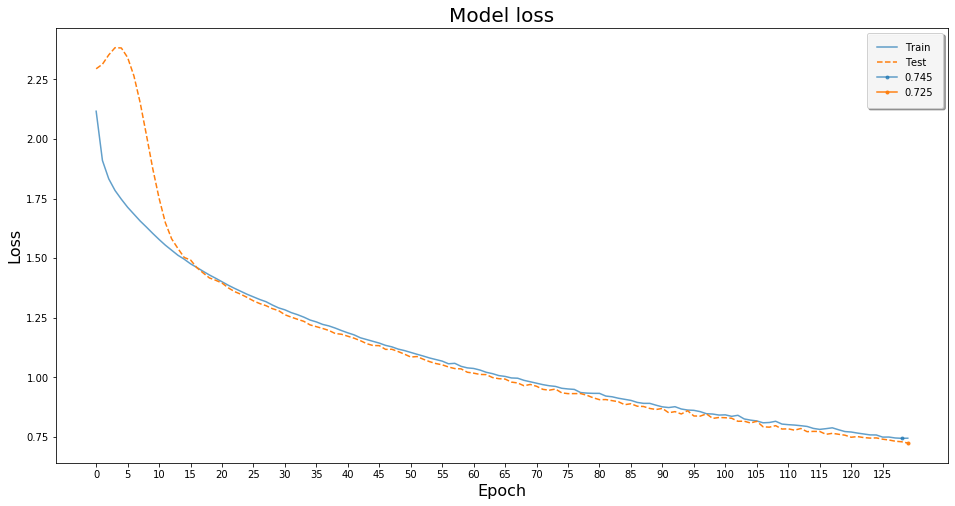

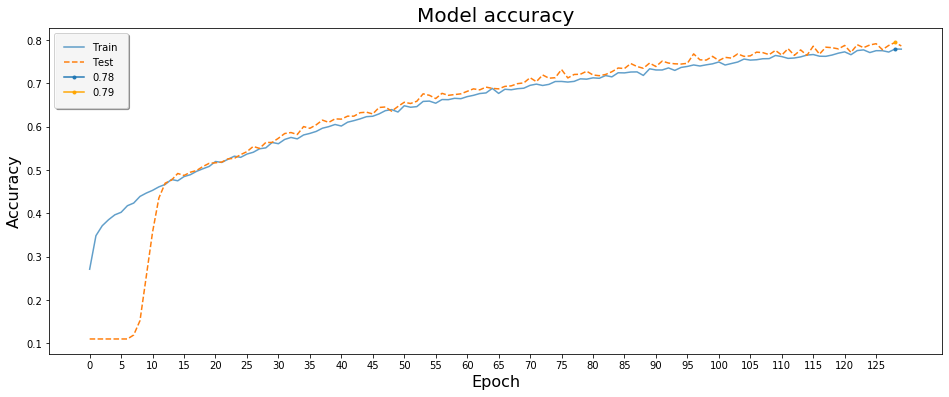

In [108]:
helpers.plot_train_history(history)

In the first plot we see the error loss per epoch. We have a small and smooth gap between validation and training, which usually talks about a "healthy" training progression.<br/>
If you look around epoch 115 you will notice how the validation loss plot starts to touch the training loss. This is a signal that, around this point, the model starts to overfit over the training data. To continue we should combine an addition of capacity with possibly some regularization.<br/>
<br/>

## 3. An improved CNN network


After more experimentation I added Max Pooling (2x2) followed by two more layers with doubled capacity (128 filters). The first layer will downsample the data reducing it's spatiality to it's half. Therefore the next two convolutional layers will be able to find patterns in a different scale (note the filter sizes are still 3x3, but the dimensions of the plane have changed).<br/>
Combining convolutional layers with max pooling is a commonly used technique, in fact what I'm doing here is replicating a basic building block of a ResNet architecture.<br/>
Regularization has been added once capacity has increased by this means as now the model will reach the prior ~76% accuracy quite fast and start overfitting.<br/>
The main regularization type I'm using is **Spatial Dropout**, which will drop complete filters by a certain rate to force the network to update others. This type of dropout is much more snesible than normal dropout and usually once would increase the rate as capacity increases (because there are more filters to drop). **L2** regularization was also added by a slight value. When using **L2** we instroduce a constraint to which the optimizer has to bond so that no weight can be updated by a value outsite this constraint.<br/>

#### Model architecture:
<br/>
    
    Segment #1
    -
    Convolution (64 filters, 5x5 size)
    BatchNormalization
    SpatialDropout (0.12)
    Convolution (64 filters, 3x3 size)
    BatchNormalization    
    -
    Segment #2
    -
    MaxPooling(2x2)
    -
    Segment #3
    -
    SpatialDropout (0.24)
    Convolution (128 filters, 3x3 size)
    BatchNormalization
    SpatialDropout (0.24)
    Convolution (128 filters, 3x3 size)
    BatchNormalization
    -
    Segment #4
    -
    GlobalAveragePooling2D
    -
    Segment #5
    -
    Dense 10 units (Softwmax output)
    
<br/>

#### Building blocks reference:

If you are already experienced with neural networks and convolutions you may want to skip the details. In other case, here is a detailed description of the building blocks:<br/>
<br/>

1. **Convolutional layers and filter amounts:** each convolutional layer will learn different features from the training data. The first layers will always learn more low level features (like lines and dots on an image, for example), while the following layers will learn more high-level patterns (basic shapes). The more complex the data is in means of patterns, the more convolutional layers that will be required learn them.<br/>On the other hand, there will always be less low-level patterns and more high-level patters (formed by combinations of those lower level patterns), that's why we keep increasing the amount of filters as we add convolutional layers to the network.

2. **Kernel sizes**: I'm using one 5x5 and 3x3 kernel sizes as the smallest size that worked out on my experiments. I also tested 7x7 -as saw on some image classifiers- but they didn't work well with this data. Also notice I use odd numbers for kernel sizes, this is a very important rule and [here is an excellent explanation](https://datascience.stackexchange.com/questions/23183/why-convolutions-always-use-odd-numbers-as-filter-size) Stackoverflow.

3. **Batch normalization**: In short, it normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This process optimizes training time. There is a [friendly introduction to batch normalization](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c) .

4. **MaxPooling**: a common technique to downsample our data reducing dimensionality, if not familiarized have a look at [this article](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) from computersciencewiki.org.

5. **Spatial dropout**: A regularization method that works like the [standard dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) used in neural networks, that applies better for convolutional layers: it works by dropping out entire feature maps by a given rate, preventing activations from becoming strongly correlated. It's effect is usually more sensible than the standard dropout and as you may have advertised I'm increasing the rate as I add new layers, this is a common practice as higher level layers are also containing more filters. Another important advice is to use it after max pooling.

6. **GlobalAveragePooling**: until some years ago it was mostly common to see CNN architectures that would flatten out the output from the last convolutional layer to connect it to a series of dense layers that would "interprete" and make category predictions. Today is more common to see this dense layers replaced with a Global Average Pooling layer that calculates the average output of each feature map in the previous layer, strongly reducing dimensionality. This demonstrated to work better in many scenarios, also being much more computationally cheap. Read more in [this article](https://principlesofdeeplearning.com/index.php/a-tutorial-on-global-average-pooling/).

7. **Dense (softmax output)**: the final layer containing the softmax output tha will provide the classification probabilities for the input data.<br/>
<br/>

#### 3.1 Model definition



In [18]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()

    # Conv 1
    model.add(Conv2D(filters=64, 
                     kernel_size=(5,5), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels), 
                     activation='relu'))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels), 
                     activation='relu'))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels), 
                     activation='relu'))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels), 
                     activation='relu'))
    model.add(BatchNormalization())


    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.16
spatial_dropout_rate_2 = 0.24
l2_rate = 0.0025

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### 3.2 Setup model optimizer and loss function

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters to start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [19]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 36, 170, 64)       1664      
_________________________________________________________________
batch_normalization_9 (Batch (None, 36, 170, 64)       256       
_________________________________________________________________
spatial_dropout2d_7 (Spatial (None, 36, 170, 64)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 168, 64)       36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 34, 168, 64)       256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 84, 64)        0         
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 17, 84, 64)       

#### 3.3 Training the model

We maintain the hyper-parameters than the prior experiment but as we added much more capacity we now train for much less epochs.
<br/>
<br/>

In [20]:
num_epochs = 51
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test_encoded), 
                    callbacks=[checkpointer], 
                    #class_weight=cw,
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6986 samples, validate on 1746 samples
Epoch 1/51
6986/6986 [==============================] - 7s 932us/step - loss: 2.6889 - accuracy: 0.2700 - val_loss: 3.1720 - val_accuracy: 0.1472

Epoch 00001: val_loss improved from inf to 3.17202, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 2/51
6986/6986 [==============================] - 6s 855us/step - loss: 2.4094 - accuracy: 0.3882 - val_loss: 3.6309 - val_accuracy: 0.0567

Epoch 00002: val_loss did not improve from 3.17202
Epoch 3/51
6986/6986 [==============================] - 6s 858us/step - loss: 2.2932 - accuracy: 0.4287 - val_loss: 4.6294 - val_accuracy: 0.0481

Epoch 00003: val_loss did not improve from 3.17202
Epoch 4/51
6986/6986 [==============================] - 6s 857us/step - loss: 2.2101 - accuracy: 0.4593 - val_loss: 5.7895 - val_accuracy: 0.0481oss: 2.2105 -  - ETA: 3s - l - ETA: 1s - loss: - ETA: 0s - loss: 2.2150 - ac

Epoch 00004: val_loss did not improve from 3.17

6986/6986 [==============================] - 6s 855us/step - loss: 1.2480 - accuracy: 0.7180 - val_loss: 1.1207 - val_accuracy: 0.7847

Epoch 00031: val_loss improved from 1.13477 to 1.12073, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 32/51
6986/6986 [==============================] - 6s 857us/step - loss: 1.2188 - accuracy: 0.7313 - val_loss: 1.1016 - val_accuracy: 0.7829

Epoch 00032: val_loss improved from 1.12073 to 1.10156, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 33/51
6986/6986 [==============================] - 6s 860us/step - loss: 1.2020 - accuracy: 0.7373 - val_loss: 1.0912 - val_accuracy: 0.7881

Epoch 00033: val_loss improved from 1.10156 to 1.09117, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 34/51
6986/6986 [==============================] - 6s 856us/step - loss: 1.1751 - accuracy: 0.7421 - val_loss: 1.0738 - val_accuracy:

#### 3.4 General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [21]:
# Load best saved model
model = load_model(model_path)

helpers.evaluate_model(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.7661       86.0865
Test:             0.7892       85.6243
Error gap %         2.93              


Compared with the previous evaluation, the new model has further minimized the loss, while the difference between Test and Train loss is still small. No signs of overfitting from this perspective.<br/>

#### 2.6 Train vs Test history plot

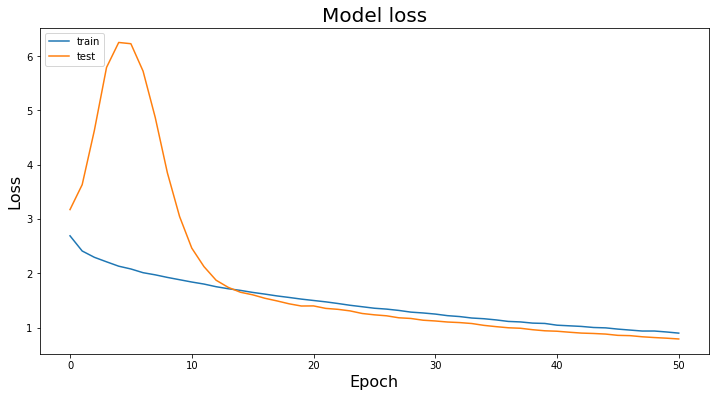

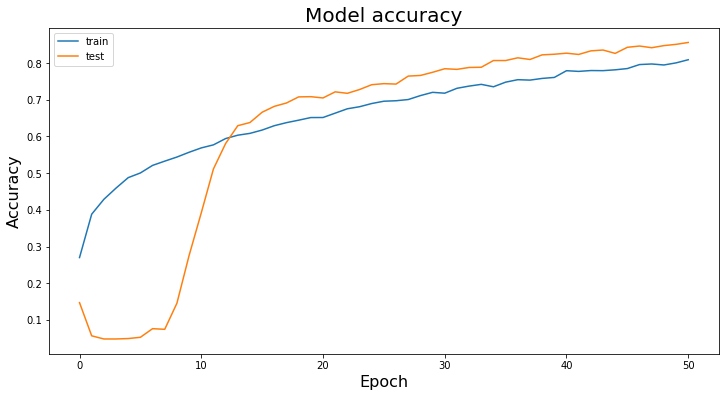

In [22]:
# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'test'], loc='upper left')
plt.figure(num=1, figsize=(10, 6))
plt.show()


The loss plot shows a thicker and still smooth gap between train and test, which is good. From this point the model will start to overfit very quickly if we keep training for just a few epochs.<br/>
<br/>
<br/>

### 4. Model evaluation
Now let's see how the model performs predicting the diferent classes using data from the test set, data that has not been used to train the model.<br/>
<br/>

#### * Register model output

In [23]:
# Add "pred" column
test_meta['pred'] = yhat_probs

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

/home/edu/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 4.1 Confussion matrix

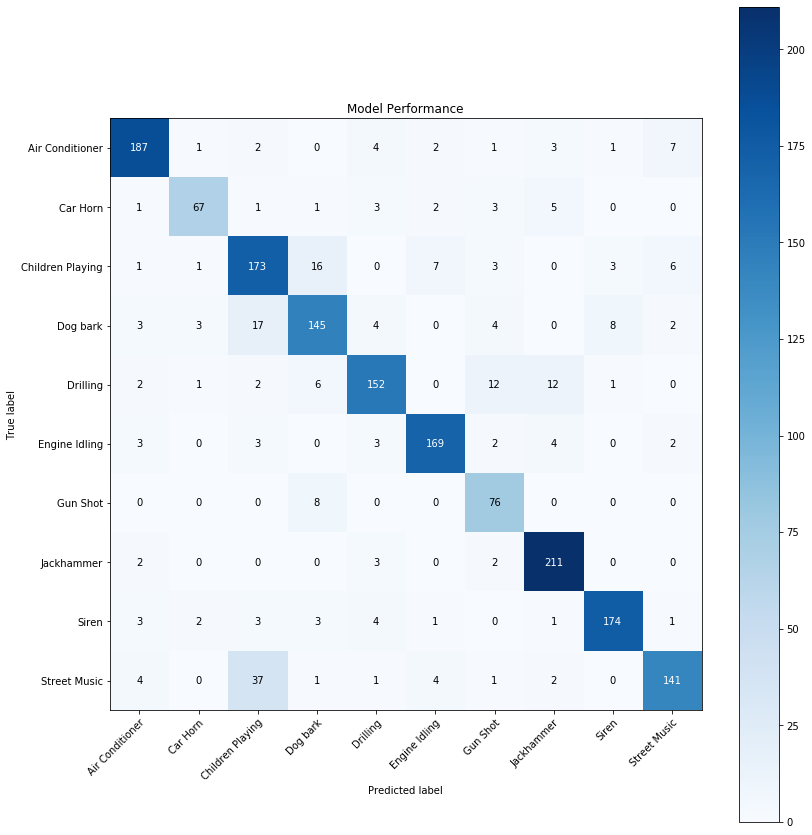

In [24]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

The most notable error is confusing **Street music** with **Children playing**. We'll see later on that this two classes sometimes share similar patterns like street ambient sound or people talking at the background.<br/>
Another case is **Children Playing** as **Dog Bark** and viceversa.<br/>
We'll also find out that other classes share characteristics, like **Drilling** and **Jack hammer**, or **Gunshot** and **Dog bark**.<br/>
<br/>

#### 4.2 Accuracy table

In [25]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

CLASS   ACCURACY
7        Jackhammer  96.788991
5     Engine Idling  90.860215
8             Siren  90.625000
6          Gun Shot  90.476190
0   Air Conditioner  89.903846
2  Children Playing  82.380952
4          Drilling  80.851064
1          Car Horn  80.722892
3          Dog bark  77.956989
9      Street Music  73.821990

We have a quite notable difference between classes over 89% accuracy and others under 70% at this point.

#### 4.3 Classification performance: Presicion, Recall and F1 scores



In [26]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.91      0.90      0.90       208
        Car Horn       0.89      0.81      0.85        83
Children Playing       0.73      0.82      0.77       210
        Dog bark       0.81      0.78      0.79       186
        Drilling       0.87      0.81      0.84       188
   Engine Idling       0.91      0.91      0.91       186
        Gun Shot       0.73      0.90      0.81        84
      Jackhammer       0.89      0.97      0.93       218
           Siren       0.93      0.91      0.92       192
    Street Music       0.89      0.74      0.81       191

        accuracy                           0.86      1746
       macro avg       0.86      0.85      0.85      1746
    weighted avg       0.86      0.86      0.86      1746



**Street music** got very low recal compared with other classes, as we expected for what we saw on the confusion matrix where many class ocurrences where classified as **Children Playing** (false negatives).<br/>
With less effect, something similar happened with **Dog Bark** and **Children Playing**, where both classes where confussed.<br/>
<br/>
From the classes that unbalanced the dataset, **Gun Shot** and **Car Horn**, the first one has low precision and as we see on the the vertical axis of the confusion matrix, it was misclassified many times (false positives). The second class has acceptable F1 score, just around the average.<br/>
<br/>

### 5. Weighted classes

Using SciKit Learn to compute a class weights we can penalize the different classes using weights that reduce or increace values during weight update.<br/>
*sklearn.utils.class_weight.compute_class_weight* looks at the distribution of labels and produces weights to equally penalize under or over-represented classes in the training set.<br/>
<br/>
<br/>

#### 5.1 Compute class weights

In [11]:
from sklearn.utils.class_weight import compute_class_weight

cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

#### 5.2 Create model

We are using the exact same hyper-parameters

In [12]:
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### 5.3 Train

In [13]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

num_epochs = 52
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test_encoded), 
                    callbacks=[checkpointer], 
                    class_weight=cw,
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 36, 170, 64)       1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 64)       256       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 36, 170, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 168, 64)       36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 34, 168, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 84, 64)        0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 17, 84, 64)       

6986/6986 [==============================] - 6s 859us/step - loss: 1.4481 - accuracy: 0.6729 - val_loss: 1.3334 - val_accuracy: 0.7291

Epoch 00023: val_loss improved from 1.36858 to 1.33338, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 24/52
6986/6986 [==============================] - 6s 860us/step - loss: 1.4104 - accuracy: 0.6884 - val_loss: 1.3005 - val_accuracy: 0.7365

Epoch 00024: val_loss improved from 1.33338 to 1.30054, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 25/52
6986/6986 [==============================] - 6s 859us/step - loss: 1.3836 - accuracy: 0.6895 - val_loss: 1.2638 - val_accuracy: 0.7457

Epoch 00025: val_loss improved from 1.30054 to 1.26381, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 26/52
6986/6986 [==============================] - 6s 860us/step - loss: 1.3628 - accuracy: 0.6995 - val_loss: 1.2481 - val_accuracy:

6986/6986 [==============================] - 6s 860us/step - loss: 0.8824 - accuracy: 0.8115 - val_loss: 0.7892 - val_accuracy: 0.8528

Epoch 00052: val_loss improved from 0.80283 to 0.78915, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Training completed in time:  0:05:19.759279


#### 5.4 General model evaluation

In [14]:
# Load best saved model
model = load_model(model_path)

helpers.evaluate_model(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.7503       86.9596
Test:             0.7892       85.2806
Error gap %         4.92              


From this results -and some other experiments- I have found that the weighted training overfits faster.

#### 5.5 Train vs Test history plot

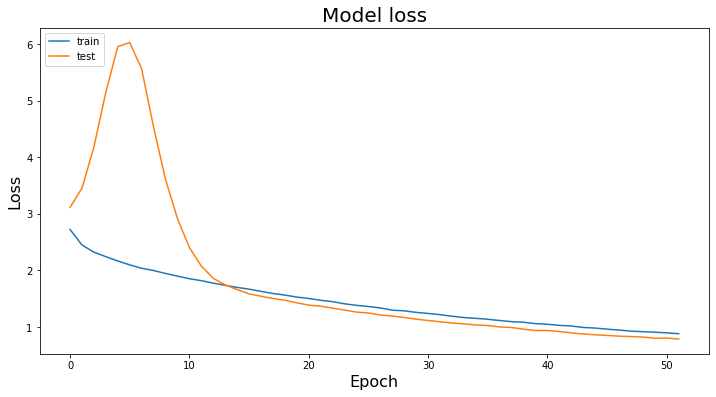

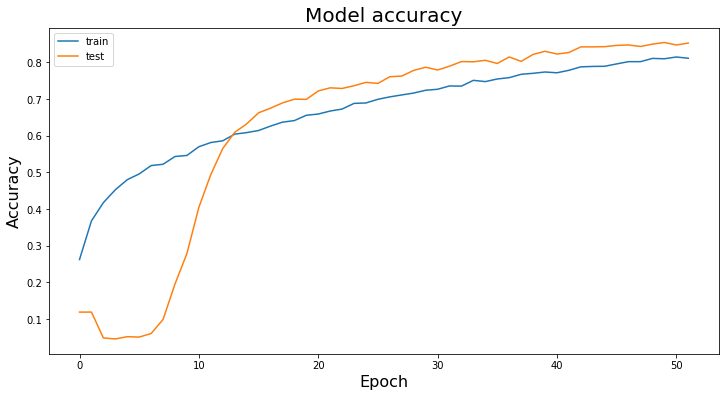

In [15]:
# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'test'], loc='upper left')
plt.figure(num=1, figsize=(10, 6))
plt.show()


The training history looks quite similar to the previous one. If you look carefully on the loss plot you will see the gap between Train and Test is getting shorter, tending to make contact.

#### 5.6 Classification performance: Presicion, Recall and F1 scores

Lets now evaluate how the weighted classes training did compared to the previous classification performance scores

In [16]:
# predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# convert to 1d
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.87      0.92      0.89       208
        Car Horn       0.88      0.84      0.86        83
Children Playing       0.74      0.80      0.77       210
        Dog bark       0.80      0.77      0.78       186
        Drilling       0.92      0.78      0.84       188
   Engine Idling       0.93      0.89      0.91       186
        Gun Shot       0.75      0.88      0.81        84
      Jackhammer       0.87      0.97      0.92       218
           Siren       0.92      0.93      0.92       192
    Street Music       0.85      0.73      0.79       191

        accuracy                           0.85      1746
       macro avg       0.85      0.85      0.85      1746
    weighted avg       0.86      0.85      0.85      1746



The scores nor the relationship between precision and recall has changed in a noticeable way. We may try something different later with augmented data or over-sampling.<br/>
<br/>

### 6. Exploring the misclassified

Warning: this is not a statistical analysis. The idea is to make some intuitions about why some samples where missclassified. We talked about similar patterns between some special classes, so, let's "see" if we can identify some of this patterns to make some more sense of what model is doing.<br/>
<br/>
**Note** that results may vary between different training sessions because of the stocastic nature of the training process. The presented results are likely be generic, but are still bound to the training session registered by this notebook.<br/>
<br/>

#### 6.1 Street music as Children playing 

In [28]:
# Find the target misclassified ocurrencies
street_as_children = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 2)]

files = []
for idx, row in street_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [54]:
print("Children playing as Street music: {} ocurrencies".format(len(street_as_children)))

# Manully set the file index
index = 33
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Children playing as Street music: 34 ocurrencies

True category: street_music
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold10/147491-9-2-6.wav


#### Observations

* In many cases the samples are clear, with foreground music and very little noise
* Many ocurrences with people talking in foreground (as it happens many times with Children Playing samples)
* Multiple cases where you barely distinguish music at the background and heavy ambiental noise

<br/>
<br/>

#### 6.2 Drilling as Jack Hammer

In [55]:
# Find the target misclassified ocurrencies
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]
files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)


In [65]:
print("Drilling as Jack Hammer: {} ocurrencies".format(len(drilling_as_jack)))

# Manully set the file index
index = 11
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Drilling as Jack Hammer: 17 ocurrencies

True category: drilling
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold9/180937-4-1-27.wav


#### Observations

Although this are very similar classes, there are some key differences like the pitch and I would also say the amplitude dynamics, while drillers sound treble and with a more constant amplitude, jack hammers sound more mid-low with a much clear percussive pattern.<br/>

* Many ocurrences are drillers that sound really bass and percussive, even a human would counfuse it
* Some ocurrences do sound like a driller

<br/>
<br/>

#### 6.3 Dog Bark as Children Playing

In [66]:
# Drilling as Air Conditioner
dogbar_as_children = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 2)]

files = []
for idx, row in dogbar_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [77]:
print("Dog Bark as Children Playing: {} ocurrencies".format(len(dogbar_as_children)))
    
# Manully set the file index
index = 8
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Dog Bark as Children Playing: 18 ocurrencies

True category: dog_bark
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold5/76566-3-0-6.wav


#### Observations

* There are cases where a dog bark sound can be identified, but also children playing in foreground
* In many cases the dog bark sound is mixed up with high ambience sound and/or people talking
* There are also very clear samples of dog bark that have not been identified

<br/>
<br/>

#### 6.4 Street Music as Air Conditioner

In [78]:
# Street Music as Air Conditioner
music_as_aircon = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 0)]

files = []
for idx, row in music_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [82]:
print("Street Music as Air Conditioner: {} ocurrencies".format(len(music_as_aircon)))

# Manully set the file index
index = 2
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Street Music as Air Conditioner: 8 ocurrencies

True category: street_music
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold5/155243-9-0-55.wav


#### Observations

* Despite of some very clear misclassification examples, there are many cases where the street music sounds very weakly in the background while, at the same time, there is much continuous noise in the mid-to-low frequencies.

* Street ambiance sound seems to be a common factor in the two classes, the model seems to fail distinguishing the most essential patterns that describe each of this two classes.
<br/>
<br/>

### 7. Conclusions

<br/>
There are clear signs of bad classification performance when the objective sound is not loud enough or when it competes strongly with other sound sources in the audio sample. The fact that this occurs very often in this dataset makes it difficult to distinguish between some classes -this maybe the reason why more scientific researches with this dataset  achieved similar accuracy than what we got (unfortunately they don't show a classification performance report to compare).<br/>

Once the model reached ~85% of general accuracy it starts to overfit, no matter how much regularization I added. I have tried many things like using different normalization methods, no normalization, using different MFCC extracting methods, more MFCC bands (up to 128) and even working with Mel Spectograms of 128 MFCC bands, nothing worked. If there is a way to get above this scores I think it would be using a more complex model like ResNets, with which more layers could be used without degradation.<br/>

<br/>
In general, and compared to other works I have found with this same dataset, we achieved some acceptable results and a piece of work to start experimenting with tweaking and optimizing once we develop some hypothesis about what the model maybe doing wrong and how can we do it better.<br/>
<br/> 

### 8. Next

I'd like to experiment with augmented data and also with more complex models to find out if I can get a more balanced F1 score between classes.<br/>
<br/>
<br/>